# **같은 title에서 바로 전 info와의 연관성**

## 훈련된 모델을 통해 예측

In [ ]:
model = keras.models.load_model("final_model_1220.h5")

In [ ]:
predicted = model.predict((train_X[:,:-3],train_X[:,-3:]))

# 그 전 문장, 그 전전 문장의 info와의 관계
- 시각화
- 상관계수

In [ ]:
# 각 문장의 바로 앞문장과, 그 앞 문장의 예측값 생성
pre_predicted1 = np.array([predicted[idx-1][0] for idx in range(len(predicted))]).reshape(-1,1) # 앞문장
pre_predicted2 = np.array([predicted[idx-2][0] for idx in range(len(predicted))]).reshape(-1,1) # 앞앞문장

In [ ]:
train["predicted"]=predicted
train["pre_predicted1"]=pre_predicted1
train["pre_predicted2"]=pre_predicted2

In [ ]:
# ord가 1,2 인 것은 제외(바로 앞, 앞앞문장이 다른 title의 문장이기 때문)
train_rest = train[(train["ord"]!=1)&(train["ord"]!=2)]

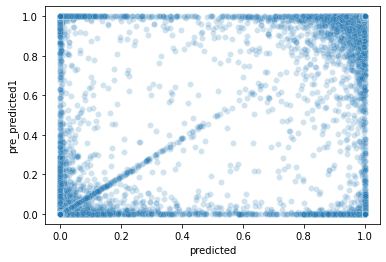

In [ ]:
# 시각화
sns.scatterplot(x="predicted",y="pre_predicted1", data=train_rest, alpha = 0.2)

In [ ]:
(train[["predicted","pre_predicted1"]]).corr()

,predicted,pre_predicted1
predicted,1.000000,0.832411
pre_predicted1,0.832411,1.000000


-> 약 83%의 상관관계

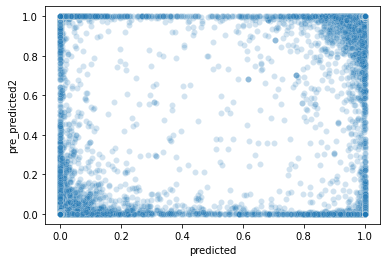

In [ ]:
# 시각화
sns.scatterplot(x="predicted",y="pre_predicted2", data=train_rest, alpha = 0.2)

In [ ]:
(train[["predicted","pre_predicted2"]]).corr()

,predicted,pre_predicted2
predicted,1.000000,0.709212
pre_predicted2,0.709212,1.000000


-> 약 71%의 상관관계

In [ ]:
train.columns

Index(['n_id', 'date', 'title', 'content', 'ord', 'info', 'info1_title',
       'new_ord', 'content_startswith_[', 'new_article', 'new_title',
       'pre_predicted1', 'pre_predicted2', 'predicted'],
      dtype='object')

# **해당 문장의 예측값과 직전 문장, 전전 문장의 예측값을 feature로 예측하는 모델 생성**

In [ ]:
!pip install lightgbm

## train, test set을 나누어 성능 확인

In [ ]:
# train, test set 분리(7:3)
predicted_train = predicted[:82858]
predicted_valid = predicted[82858:]

### 예측값 생성

In [ ]:
# 예측값 생성

# idx-1의 예측값
pre_predicted_train = np.array([predicted_train[idx-1][0] for idx in range(len(predicted_train))]).reshape(-1,1)
pre_predicted_valid = np.array([predicted_valid[idx-1][0] for idx in range(len(predicted_valid))]).reshape(-1,1)
# idx-2의 예측값
pre_predicted_train2 = np.array([predicted_train[idx-2][0] for idx in range(len(predicted_train))]).reshape(-1,1)
pre_predicted_valid2 = np.array([predicted_valid[idx-2][0] for idx in range(len(predicted_valid))]).reshape(-1,1)
# idx-3의 예측값
#pre_predicted_train3 = np.array([predicted_train[idx-3][0] for idx in range(len(predicted_train))]).reshape(-1,1)
#pre_predicted_valid3 = np.array([predicted_valid[idx-3][0] for idx in range(len(predicted_valid))]).reshape(-1,1)

### ord가 1 혹은 2인 경우 해당 문장의 값으로 대체(앞문장, 앞앞문장이 같은 title의 문장이 아니기 때문)

In [ ]:
# ord1가 1이면 자기 값으로 대체
pre_predicted_train[train[:82858]["ord"]==1]=predicted_train[train[:82858]["ord"]==1]
pre_predicted_valid[train[82858:]["ord"]==1]=predicted_valid[train[82858:]["ord"]==1]
# ord가 2이면 자기 값으로 대체
pre_predicted_train2[train[:82858]["ord"]==2]=predicted_train[train[:82858]["ord"]==2]
pre_predicted_valid2[train[82858:]["ord"]==2]=predicted_valid[train[82858:]["ord"]==2]
# ord가 3이면 자기값으로 대체
#pre_predicted_train3[train[:82858]["ord"]==3]=predicted_train[train[:82858]["ord"]==3]
#pre_predicted_valid3[train[82858:]["ord"]==3]=predicted_valid[train[82858:]["ord"]==3]

# concat(앞 2문장의 예측값 반영)
X_train2 = np.concatenate([predicted_train, pre_predicted_train, pre_predicted_train2], axis=1)
X_valid2 = np.concatenate([predicted_valid, pre_predicted_valid, pre_predicted_valid2], axis=1)

In [ ]:
import lightgbm
tree = lightgbm.LGBMClassifier(max_depth = 2, random_state = 42)
tree.fit(X_train2, train["info"][:82858])
predicted = tree.predict(X_valid2)

((predicted==train["info"][82858:]).sum())/len(X_valid2)

0.9994937563280459

-> validation set 기준 기존 98.83%의 정확도보다 더 좋은 정확도를 보임

## 예측을 위한 test preprocessing

In [ ]:
# 내 드라이브에 대한 주소
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4MB 57.4MB/s 
     |████████████████████████████████| 460kB 44.7MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/ls

In [ ]:
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '▶' ,'◆','★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
  if ("종목" in x["title"][-6:]) or ("관련주" in x["title"][-5:]):
    return 1
  elif (x["content"]=="코스피") or (x["content"]=="코스닥"):
    return 1
  for noise in title_noise:
    if noise in x["title"].upper():
      if (x["content"][:2]=="제목") or (x["content"][:1]=="["):
        return 0
      else:
        return 1
  return 0

In [ ]:
train["info1_title"]=train.apply(title_choose, axis=1)

# Order을 이용한 feature

In [ ]:
title_group = (train.groupby(["title"]).count())["n_id"]
train["new_ord"]=train.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

# content 맨앞이 [이거나 (이면 0

In [ ]:
train["content_startswith_["]=train.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") )+0

# tokenization

In [ ]:
from konlpy.tag import Mecab
import re

"""'로','으로', '다', '했', '에', '의', '에서', '부터', '아', '하','고','도','것','그','으로','해진
['을', '를', '이', '가', '은', '는', 'null','부터','에','에서','하','고','으로','로','의','만','하','고','도','았','었','다'"""

def text_preprocessing(text_list):
    
    stopwords = [] #불용어 설정
    
    tokenizer = Mecab() #형태소 분석기 
    token_list = [] 
    
    for text in text_list:
        txt = re.sub('[^가-힣]', ' ', text) #한글, 영어만 남기고 다른 글자 모두 제거
        txt = re.sub('[가-힣\s]+기자]','기자', txt) #기자 이름 제거
        token = tokenizer.morphs(txt) #형태소 분석

        #형태소 분석 결과 중 stopwords에 해당하지 않고, float type이 아닌 것만 수집
        token = [t for t in token] 
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다. 
train['new_article'], mecab = text_preprocessing(train['content'])
#title도 동일하게 진행
train['new_title'], title_mecab = text_preprocessing(train['title'])

In [ ]:
# 결측치 제거
train = train[train["new_article"].apply(lambda x: False if len(x)==0 else True)]

# Vectorization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len, truncating="post") # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = max_len)

print(train_X.shape, train_y.shape)

vocab_size :  33461
(118414, 40) (118414,)


# Word2Vec

In [ ]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
path = "/gdrive/My Drive/"

In [ ]:
"""
# 구글 word2vec 모델
word2vec_g = gensim.models.KeyedVectors.load_word2vec_format(path+'/GoogleNews-vectors-negative300.bin.gz', binary = True)
embedding_size = 300

# fasttext
from gensim.models.keyedvectors import KeyedVectors
path = "/gdrive/My Drive"
word2vec_f = KeyedVectors.load_word2vec_format(path+'/fasttext.bin', binary = True, encoding = "utf-8")
"""

In [ ]:
# 한국어 word2vec model
word2vec = gensim.models.Word2Vec.load(path+'ko.bin')
embedding_size = 200

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))
vocab = vectorizer.word_index
count = 0

for idx, word in enumerate(vocab):
    if word in word2vec:
      embedding_vector = word2vec[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
      print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
임이자 word2vec에 없는 단어입니다.
이한성 word2vec에 없는 단어입니다.
전상헌 word2vec에 없는 단어입니다.
강부 word2vec에 없는 단어입니다.
장세호 word2vec에 없는 단어입니다.
정희용 word2vec에 없는 단어입니다.
권수현 word2vec에 없는 단어입니다.
소방위 word2vec에 없는 단어입니다.
김서영 word2vec에 없는 단어입니다.
밝혔으나 word2vec에 없는 단어입니다.
에퀴 word2vec에 없는 단어입니다.
우성문 word2vec에 없는 단어입니다.
기우뚱 word2vec에 없는 단어입니다.
손형주 word2vec에 없는 단어입니다.
기울어진 word2vec에 없는 단어입니다.
그린코 word2vec에 없는 단어입니다.
연약지반 word2vec에 없는 단어입니다.
개였 word2vec에 없는 단어입니다.
허심탄회 word2vec에 없는 단어입니다.
끝냈으면 word2vec에 없는 단어입니다.
김계환 word2vec에 없는 단어입니다.
발선 word2vec에 없는 단어입니다.
돗 word2vec에 없는 단어입니다.
바통 word2vec에 없는 단어입니다.
당우 word2vec에 없는 단어입니다.
석패 word2vec에 없는 단어입니다.
개각 word2vec에 없는 단어입니다.
오월동주 word2vec에 없는 단어입니다.
뒤졌 word2vec에 없는 단어입니다.
법심 word2vec에 없는 단어입니다.
담상 word2vec에 없는 단어입니다.
가와이 word2vec에 없는 단어입니다.
가쓰유키 word2vec에 없는 단어입니다.
점찍 word2vec에 없는 단어입니다.
기시다 word2vec에 없는 단어입니다.
후미오 word2vec에 없는 단어입니다.
다로 word2vec에 없는 단어입니다.
뉘른베르크 word2vec에 없는 단어입니다.
도미이치 word2vec에 없는 단어입니다.
공통분모 word2vec에 없는 단어입니다.
억지력 word

In [ ]:
count

2493

# feature 합치기

In [ ]:
train_X = np.concatenate([train_X,train[["info1_title","new_ord","content_startswith_["]].values.reshape(-1,3)], axis=1)